In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/student-depression-dataset/student_depression_dataset.csv


In [2]:
# Cell 0: Setup

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import io
import base64
import gc
import google.generativeai as genai
import pickle # <-- For saving/loading results
from kaggle_secrets import UserSecretsClient
from IPython.display import HTML, display, FileLink

print("--- Running Setup ---")

# --- Configuration ---
DATASET_PATH = '/kaggle/input/student-depression-dataset/student_depression_dataset.csv' # Your dataset path
OUTPUT_DIR = '/kaggle/working/output'
RESULTS_FILE = os.path.join(OUTPUT_DIR, 'analysis_results.pkl') # File to save state

os.makedirs(OUTPUT_DIR, exist_ok=True)
print(f"Output directory: {OUTPUT_DIR}")
print(f"Results file: {RESULTS_FILE}")

# --- Load API Key ---
API_SECRET_LABEL = "GOOGLE_API" # Your secret label
gemini_ready = False
try:
    user_secrets = UserSecretsClient()
    GEMINI_API_KEY = user_secrets.get_secret(API_SECRET_LABEL)
    genai.configure(api_key=GEMINI_API_KEY)
    print("Gemini client configured successfully.")
    gemini_ready = True
except Exception as e:
    print(f"WARNING: Error loading/configuring API Key '{API_SECRET_LABEL}': {e}. LLM features disabled.")

# --- Load Data ---
df = None
try:
    df = pd.read_csv(DATASET_PATH)
    print(f"Dataset loaded successfully from: {DATASET_PATH}")
    print(f"Dataset shape: {df.shape}")
except Exception as e:
    print(f"ERROR: Failed to load dataset: {e}")

# --- Initialize and Save Initial Results ---
analysis_results = {}
if df is not None:
    analysis_results['dataset_path'] = DATASET_PATH
    analysis_results['output_dir'] = OUTPUT_DIR
    analysis_results['shape'] = df.shape
    analysis_results['gemini_configured'] = gemini_ready
    analysis_results['head'] = df.head() # Store head/tail early
    analysis_results['tail'] = df.tail()
    # Initialize dictionaries needed later
    analysis_results['plot_paths'] = {}
    analysis_results['narratives'] = {}
    analysis_results['numerical_skewness'] = {}
    analysis_results['anomaly_results'] = {}
    analysis_results['clustering_results'] = {}
    analysis_results['time_analysis_skipped'] = True # Default
    analysis_results['time_analysis_reason'] = "Analysis not attempted." # Default

    try:
        with open(RESULTS_FILE, 'wb') as f:
            pickle.dump(analysis_results, f)
        print(f"Initial analysis results saved to {RESULTS_FILE}")
    except Exception as e:
        print(f"ERROR: Failed to save initial results: {e}")
else:
    print("ERROR: Cannot proceed without loaded DataFrame.")

print("\n--- Setup Complete ---")

--- Running Setup ---
Output directory: /kaggle/working/output
Results file: /kaggle/working/output/analysis_results.pkl
Gemini client configured successfully.
Dataset loaded successfully from: /kaggle/input/student-depression-dataset/student_depression_dataset.csv
Dataset shape: (27901, 18)
Initial analysis results saved to /kaggle/working/output/analysis_results.pkl

--- Setup Complete ---


In [3]:
# Cell 1: Core Analysis

import pandas as pd
import numpy as np
import os
import pickle
import io

print("--- Running Core Analysis ---")

# --- Load Previous Results ---
RESULTS_FILE = '/kaggle/working/output/analysis_results.pkl' # Define again or get from results
analysis_results = None
if os.path.exists(RESULTS_FILE):
    try:
        with open(RESULTS_FILE, 'rb') as f:
            analysis_results = pickle.load(f)
        print(f"Loaded previous results from {RESULTS_FILE}")
    except Exception as e:
        print(f"ERROR: Failed to load results file '{RESULTS_FILE}': {e}. Cannot proceed.")
        # exit() # Or handle error
else:
    print(f"ERROR: Results file '{RESULTS_FILE}' not found. Run Setup cell first.")
    # exit() # Or handle error

# Ensure df is loaded (it should be in memory if setup ran in same session,
# but robustly you might pass df path via results and reload here)
# For now, assume 'df' exists from the setup cell if analysis_results loaded.
if analysis_results and 'df' in locals() and df is not None:
    try:
        print("Performing core analysis calculations...")
        # Buffer for df.info()
        buffer = io.StringIO()
        df.info(buf=buffer)
        analysis_results['df_info'] = buffer.getvalue()

        # Describe
        analysis_results['summary_stats'] = df.describe(include='all')
        print(" - Calculated summary stats.")

        # Missing Values
        missing_values_all = df.isnull().sum()
        analysis_results['missing_values'] = missing_values_all[missing_values_all > 0]
        print(f" - Found missing values in columns: {analysis_results['missing_values'].index.tolist() if not analysis_results['missing_values'].empty else 'None'}")

        # Unique Counts
        analysis_results['unique_counts'] = df.nunique()
        print(" - Calculated unique counts.")

        # --- Save Updated Results ---
        try:
            with open(RESULTS_FILE, 'wb') as f:
                pickle.dump(analysis_results, f)
            print(f"Core analysis results saved to {RESULTS_FILE}")
            print("\n--- Core Analysis Complete ---")
            print("Proceed to next cell (Visualizations).")
        except Exception as e:
            print(f"ERROR: Failed to save core analysis results: {e}")

    except Exception as e:
        print(f"ERROR during Core Analysis processing: {e}")
else:
     if not analysis_results:
         print("Cannot run Core Analysis: analysis_results failed to load.")
     else:
         print("Cannot run Core Analysis: DataFrame 'df' not found in memory.")

--- Running Core Analysis ---
Loaded previous results from /kaggle/working/output/analysis_results.pkl
Performing core analysis calculations...
 - Calculated summary stats.
 - Found missing values in columns: None
 - Calculated unique counts.
Core analysis results saved to /kaggle/working/output/analysis_results.pkl

--- Core Analysis Complete ---
Proceed to next cell (Visualizations).


--- Running Basic Visualizations ---
Loaded previous results from /kaggle/working/output/analysis_results.pkl
Numerical columns for histograms: ['id', 'Age', 'Academic Pressure', 'Work Pressure', 'CGPA', 'Study Satisfaction', 'Job Satisfaction', 'Work/Study Hours', 'Depression']


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

 - Error plotting/saving hist for Work/Study Hours: [Errno 2] No such file or directory: '/kaggle/working/output/hist_Work/Study Hours.png'


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Categorical columns for count plots: ['Dietary Habits', 'Family History of Mental Illness', 'Financial Stress', 'Gender', 'Have you ever had suicidal thoughts ?', 'Profession', 'Sleep Duration']
Basic visualizations successful.
Visualization results saved to /kaggle/working/output/analysis_results.pkl

--- Basic Visualizations Complete ---
Proceed to next cell (Correlation Analysis).


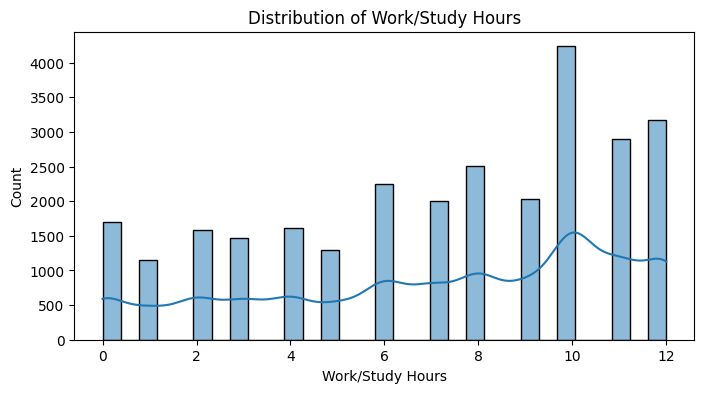

In [4]:
# Cell 2: Basic Visualizations

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
import gc

print("--- Running Basic Visualizations ---")

# --- Configuration ---
# Ensure these match the paths used in previous cells
OUTPUT_DIR = '/kaggle/working/output'
RESULTS_FILE = os.path.join(OUTPUT_DIR, 'analysis_results.pkl')

# --- Load Previous Results ---
analysis_results = None
if os.path.exists(RESULTS_FILE):
    try:
        with open(RESULTS_FILE, 'rb') as f:
            analysis_results = pickle.load(f)
        print(f"Loaded previous results from {RESULTS_FILE}")
    except Exception as e:
        print(f"ERROR: Failed to load results file '{RESULTS_FILE}': {e}. Cannot proceed.")
        # exit() or handle
else:
    print(f"ERROR: Results file '{RESULTS_FILE}' not found. Run previous cells first.")
    # exit() or handle

# --- Check if DataFrame 'df' exists (essential) ---
# If df wasn't saved/passed, this check fails. Robust way is to load df from path in results.
# For now, assume 'df' is still in memory from Cell 0 if results loaded.
if 'df' not in locals() or df is None:
     print("ERROR: DataFrame 'df' not found in memory. Please re-run Cell 0 (Setup).")
     # exit() or handle
elif analysis_results: # Proceed only if results were loaded

    # --- Initialize dicts if they don't exist (safety check) ---
    analysis_results.setdefault('plot_paths', {}).setdefault('histograms', {})
    analysis_results['plot_paths'].setdefault('count_plots', {})
    analysis_results.setdefault('numerical_skewness', {})

    try: # Wrap main logic
        # --- Numerical Histograms & Skewness ---
        numerical_cols = df.select_dtypes(include=np.number).columns.tolist()
        numerical_cols_to_plot = [col for col in numerical_cols if col not in ['PassengerId', 'Survived', 'Pclass']]
        print(f"Numerical columns for histograms: {numerical_cols_to_plot}")

        for col in numerical_cols_to_plot:
            try:
                fig, ax = plt.subplots(figsize=(8, 4))
                sns.histplot(df[col].dropna(), kde=True, ax=ax)
                ax.set_title(f'Distribution of {col}')
                plot_filename = os.path.join(OUTPUT_DIR, f'hist_{col}.png')
                fig.savefig(plot_filename)
                plt.close(fig) # Close the specific figure

                if os.path.exists(plot_filename):
                    # Store relative path if desired, or keep absolute
                    analysis_results['plot_paths']['histograms'][col] = plot_filename
                else:
                     print(f" - FAILED to save hist for {col}")

                # Calculate skewness
                analysis_results['numerical_skewness'][col] = df[col].skew()
            except Exception as e:
                print(f" - Error plotting/saving hist for {col}: {e}")

        # --- Categorical Count Plots ---
        categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
        potential_numeric_cats = ['Survived', 'Pclass']
        for col_p in potential_numeric_cats:
             if col_p in df.columns and col_p not in categorical_cols: categorical_cols.append(col_p)

        # Get unique counts from loaded results
        unique_counts = analysis_results.get('unique_counts')
        if unique_counts is None:
             print("WARNING: Unique counts not found in loaded results. Calculating again.")
             unique_counts = df.nunique() # Recalculate if missing

        MAX_CATEGORIES_FOR_PLOT = 25
        categorical_cols_to_plot = sorted(list(set([c for c in categorical_cols if c in unique_counts and unique_counts[c] <= MAX_CATEGORIES_FOR_PLOT])))
        print(f"Categorical columns for count plots: {categorical_cols_to_plot}")

        for col_c in categorical_cols_to_plot:
            if col_c not in df.columns: continue
            try:
                fig, ax = plt.subplots(figsize=(8, 4))
                sns.countplot(data=df, x=col_c, order=df[col_c].value_counts().index, ax=ax)
                ax.set_title(f'Count Plot for {col_c}')
                if len(df[col_c].unique()) > 5:
                    ax.tick_params(axis='x', rotation=45)
                fig.tight_layout()
                plot_filename = os.path.join(OUTPUT_DIR, f'count_{col_c}.png')
                fig.savefig(plot_filename)
                plt.close(fig)
                if os.path.exists(plot_filename):
                     analysis_results['plot_paths']['count_plots'][col_c] = plot_filename
            except Exception as e:
                 print(f" - Error plotting/saving count plot for {col_c}: {e}")

        print("Basic visualizations successful.")

        # --- Save Updated Results ---
        try:
            with open(RESULTS_FILE, 'wb') as f:
                pickle.dump(analysis_results, f)
            print(f"Visualization results saved to {RESULTS_FILE}")
            print("\n--- Basic Visualizations Complete ---")
            print("Proceed to next cell (Correlation Analysis).")
        except Exception as e:
            print(f"ERROR: Failed to save visualization results: {e}")

    except Exception as e:
        print(f"ERROR during Basic Visualizations processing: {e}")

    gc.collect() # Garbage collect

In [5]:
# Cell 3: Correlation Analysis

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
import gc

print("--- Running Correlation Analysis ---")

# --- Configuration ---
OUTPUT_DIR = '/kaggle/working/output'
RESULTS_FILE = os.path.join(OUTPUT_DIR, 'analysis_results.pkl')

# --- Load Previous Results ---
analysis_results = None
if os.path.exists(RESULTS_FILE):
    try:
        with open(RESULTS_FILE, 'rb') as f:
            analysis_results = pickle.load(f)
        print(f"Loaded previous results from {RESULTS_FILE}")
    except Exception as e:
        print(f"ERROR: Failed to load results file '{RESULTS_FILE}': {e}. Cannot proceed.")
        # exit() or handle
else:
    print(f"ERROR: Results file '{RESULTS_FILE}' not found. Run previous cells first.")
    # exit() or handle

# --- Check if DataFrame 'df' exists ---
if 'df' not in locals() or df is None:
     print("ERROR: DataFrame 'df' not found in memory. Please re-run Cell 0 (Setup).")
     # exit() or handle
elif analysis_results: # Proceed only if results were loaded

    # --- Initialize keys ---
    analysis_results['correlation_skipped'] = True
    analysis_results.setdefault('plot_paths', {}) # Ensure plot_paths exists
    analysis_results['highly_correlated_pairs'] = []

    try: # Wrap main logic
        # --- Select Numerical Columns ---
        # Exclude IDs, and optionally discrete categoricals like Survived/Pclass
        cols_for_corr = [col for col in df.select_dtypes(include=np.number).columns.tolist() if col not in ['PassengerId', 'Survived']]

        if len(cols_for_corr) >= 2:
            print(f"Calculating correlation matrix for: {cols_for_corr}")

            # --- Calculate Correlation ---
            correlation_matrix = df[cols_for_corr].corr()
            analysis_results['correlation_matrix'] = correlation_matrix # Store matrix if needed later
            analysis_results['correlation_skipped'] = False

            # --- Generate Heatmap ---
            try:
                fig, ax = plt.subplots(figsize=(10, 8))
                sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, ax=ax)
                ax.set_title('Correlation Matrix')
                fig.tight_layout()
                plot_filename = os.path.join(OUTPUT_DIR, 'correlation_heatmap.png')
                fig.savefig(plot_filename)
                plt.close(fig) # Close figure

                if os.path.exists(plot_filename):
                    analysis_results['plot_paths']['heatmap'] = plot_filename
                    print(" - Saved correlation heatmap.")
                else:
                     print(" - FAILED to save correlation heatmap.")
            except Exception as e:
                 print(f" - Error generating/saving heatmap: {e}")

            # --- Identify Highly Correlated Pairs ---
            CORR_THRESHOLD = 0.4
            print(f" - Identifying pairs with absolute correlation > {CORR_THRESHOLD}")
            # Unstack matrix, remove self-correlation, filter by threshold
            corr_unstacked = correlation_matrix.unstack()
            strong_pairs_series = corr_unstacked[(abs(corr_unstacked) > CORR_THRESHOLD) & (corr_unstacked != 1.0)]

            highly_corr_pairs_list = []
            seen_pairs = set()
            for (var1, var2), corr_value in strong_pairs_series.items():
                pair = tuple(sorted((var1, var2))) # Ensure ('A','B') is same as ('B','A')
                if pair not in seen_pairs:
                    highly_corr_pairs_list.append(((var1, var2), corr_value))
                    seen_pairs.add(pair)

            analysis_results['highly_correlated_pairs'] = highly_corr_pairs_list
            if highly_corr_pairs_list:
                 print(f" - Found pairs: {highly_corr_pairs_list}")
            else:
                 print(" - No pairs found above threshold.")

        else:
            print("Skipping correlation analysis: Need at least 2 numerical columns.")
            analysis_results['correlation_skipped'] = True

        print("Correlation analysis successful.")

        # --- Save Updated Results ---
        try:
            with open(RESULTS_FILE, 'wb') as f:
                pickle.dump(analysis_results, f)
            print(f"Correlation results saved to {RESULTS_FILE}")
            print("\n--- Correlation Analysis Complete ---")
            print("Proceed to next cell (Anomaly Detection).")
        except Exception as e:
            print(f"ERROR: Failed to save correlation results: {e}")

    except Exception as e:
        print(f"ERROR during Correlation Analysis processing: {e}")

    gc.collect() # Garbage collect

--- Running Correlation Analysis ---
Loaded previous results from /kaggle/working/output/analysis_results.pkl
Calculating correlation matrix for: ['id', 'Age', 'Academic Pressure', 'Work Pressure', 'CGPA', 'Study Satisfaction', 'Job Satisfaction', 'Work/Study Hours', 'Depression']
 - Saved correlation heatmap.
 - Identifying pairs with absolute correlation > 0.4
 - Found pairs: [(('Academic Pressure', 'Depression'), 0.474834943980666), (('Work Pressure', 'Job Satisfaction'), 0.7706521656642141)]
Correlation analysis successful.
Correlation results saved to /kaggle/working/output/analysis_results.pkl

--- Correlation Analysis Complete ---
Proceed to next cell (Anomaly Detection).


In [6]:
# Cell 4: Anomaly Detection

import pandas as pd
import numpy as np
import os
import pickle
import gc
from sklearn.ensemble import IsolationForest
from sklearn.impute import SimpleImputer

print("--- Running Anomaly Detection (Isolation Forest) ---")

# --- Configuration ---
OUTPUT_DIR = '/kaggle/working/output'
RESULTS_FILE = os.path.join(OUTPUT_DIR, 'analysis_results.pkl')

# --- Load Previous Results ---
analysis_results = None
if os.path.exists(RESULTS_FILE):
    try:
        with open(RESULTS_FILE, 'rb') as f:
            analysis_results = pickle.load(f)
        print(f"Loaded previous results from {RESULTS_FILE}")
    except Exception as e:
        print(f"ERROR: Failed to load results file '{RESULTS_FILE}': {e}. Cannot proceed.")
        # exit() or handle
else:
    print(f"ERROR: Results file '{RESULTS_FILE}' not found. Run previous cells first.")
    # exit() or handle

# --- Check if DataFrame 'df' exists ---
if 'df' not in locals() or df is None:
     print("ERROR: DataFrame 'df' not found in memory. Please re-run Cell 0 (Setup).")
     # exit() or handle
elif analysis_results: # Proceed only if results were loaded

    # --- Initialize keys ---
    analysis_results['anomaly_skipped'] = True
    analysis_results.setdefault('anomaly_results', {}) # Ensure nested dict exists
    anomaly_features = ['Age', 'SibSp', 'Parch', 'Fare'] # Features for anomaly detection
    analysis_results['anomaly_results']['features_used'] = anomaly_features

    try: # Wrap main logic
        # Select data and handle potential missing columns
        available_features = [f for f in anomaly_features if f in df.columns]
        if len(available_features) < 1:
             print("Skipping anomaly detection: None of the specified features exist in the DataFrame.")
        else:
            print(f"Using features for anomaly detection: {available_features}")
            df_anomaly = df[available_features].copy()

            # Check if data is purely NaN before imputing
            if not df_anomaly.empty and df_anomaly.notna().any().any():
                # Impute missing values FOR THE MODEL ONLY
                imputer_ad = SimpleImputer(strategy='median')
                df_anomaly_imputed = imputer_ad.fit_transform(df_anomaly)
                # Keep as numpy array for IsolationForest, avoid DataFrame conversion if not needed
                # df_anomaly_imputed_df = pd.DataFrame(df_anomaly_imputed, columns=available_features, index=df_anomaly.index)

                imputed_cols_msg = [f"{col}({imputer_ad.statistics_[available_features.index(col)]:.2f})" for col in available_features if df_anomaly[col].isnull().any()]
                if imputed_cols_msg:
                     print(f" - Imputed NaNs for anomaly detection in: {', '.join(imputed_cols_msg)}.")

                # Fit Isolation Forest
                iso_forest = IsolationForest(contamination='auto', random_state=42)
                predictions = iso_forest.fit_predict(df_anomaly_imputed) # Use imputed numpy array

                # Store results
                analysis_results['anomaly_results']['predictions'] = predictions # Optional: store predictions
                analysis_results['anomaly_results']['count'] = np.sum(predictions == -1)
                analysis_results['anomaly_results']['percentage'] = (np.mean(predictions == -1) * 100)
                analysis_results['anomaly_skipped'] = False

                print(f"Anomaly detection successful.")
                print(f" - Found {analysis_results['anomaly_results']['count']} potential anomalies ({analysis_results['anomaly_results']['percentage']:.2f}%).")
                # del df_anomaly_imputed_df # Clean up if created
            else:
                print("Skipping anomaly detection: No suitable features or only NaN values after selection.")

    except Exception as e:
        print(f"ERROR during Anomaly Detection processing: {e}")

    # --- Save Updated Results ---
    if analysis_results: # Ensure results exist before saving
        try:
            with open(RESULTS_FILE, 'wb') as f:
                pickle.dump(analysis_results, f)
            print(f"Anomaly detection results saved to {RESULTS_FILE}")
            print("\n--- Anomaly Detection Complete ---")
            print("Proceed to next cell (Clustering Exploration).")
        except Exception as e:
            print(f"ERROR: Failed to save anomaly detection results: {e}")

    gc.collect() # Garbage collect

--- Running Anomaly Detection (Isolation Forest) ---
Loaded previous results from /kaggle/working/output/analysis_results.pkl
Using features for anomaly detection: ['Age']
Anomaly detection successful.
 - Found 23510 potential anomalies (84.26%).
Anomaly detection results saved to /kaggle/working/output/analysis_results.pkl

--- Anomaly Detection Complete ---
Proceed to next cell (Clustering Exploration).


In [7]:
# Cell 5: Clustering Exploration

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
import gc
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA

print("--- Running Clustering Exploration (K-Means) ---")

# --- Configuration ---
OUTPUT_DIR = '/kaggle/working/output'
RESULTS_FILE = os.path.join(OUTPUT_DIR, 'analysis_results.pkl')

# --- Load Previous Results ---
analysis_results = None
if os.path.exists(RESULTS_FILE):
    try:
        with open(RESULTS_FILE, 'rb') as f:
            analysis_results = pickle.load(f)
        print(f"Loaded previous results from {RESULTS_FILE}")
    except Exception as e:
        print(f"ERROR: Failed to load results file '{RESULTS_FILE}': {e}. Cannot proceed.")
        # exit() or handle
else:
    print(f"ERROR: Results file '{RESULTS_FILE}' not found. Run previous cells first.")
    # exit() or handle

# --- Check if DataFrame 'df' exists ---
if 'df' not in locals() or df is None:
     print("ERROR: DataFrame 'df' not found in memory. Please re-run Cell 0 (Setup).")
     # exit() or handle
elif analysis_results: # Proceed only if results were loaded

    # --- Initialize keys ---
    analysis_results['clustering_skipped'] = True
    analysis_results.setdefault('clustering_results', {}) # Ensure nested dict exists
    analysis_results['plot_paths'].setdefault('clustering_pca', None) # Specific key for plot

    clustering_features = ['Age', 'Fare', 'SibSp', 'Parch'] # Features to use
    n_clusters_fixed = 4 # Fixed number of clusters for this example
    analysis_results['clustering_results']['n_clusters'] = n_clusters_fixed
    analysis_results['clustering_results']['features_used'] = clustering_features # Store features used

    try: # Wrap main logic
        # Select data and check validity
        available_features = [f for f in clustering_features if f in df.columns]
        if len(available_features) < 2:
            print("Skipping clustering: Not enough specified features exist in the DataFrame.")
            analysis_results['clustering_reason'] = "Not Applicable: Insufficient features."
        else:
            df_cluster_orig = df[available_features].copy()
            # Check if data is purely NaN before imputing/fitting
            if not df_cluster_orig.empty and df_cluster_orig.notna().any().any():
                print(f"Using features for clustering: {available_features}")

                # --- Preprocessing ---
                imputer_cl = SimpleImputer(strategy='median')
                df_cluster_imputed = imputer_cl.fit_transform(df_cluster_orig)
                df_cluster_imputed_df = pd.DataFrame(df_cluster_imputed, columns=available_features, index=df_cluster_orig.index)
                print(" - Imputed missing values for clustering using median.")

                scaler = StandardScaler()
                df_cluster_scaled = scaler.fit_transform(df_cluster_imputed_df)
                print(" - Scaled features using StandardScaler.")

                # --- Run K-Means ---
                kmeans = KMeans(n_clusters=n_clusters_fixed, n_init='auto', random_state=42)
                cluster_labels = kmeans.fit_predict(df_cluster_scaled)
                analysis_results['clustering_results']['labels'] = cluster_labels
                df_cluster_imputed_df['Cluster'] = cluster_labels # Add labels for analysis
                print(f" - K-Means clustering performed with K={n_clusters_fixed}.")

                # --- Analyze Clusters ---
                cluster_summary = df_cluster_imputed_df.groupby('Cluster')[available_features].mean().round(2)
                analysis_results['clustering_results']['summary_stats'] = cluster_summary
                print(" - Calculated cluster characteristics (mean values):")
                print(cluster_summary)

                # --- Visualize Clusters (PCA) ---
                try:
                     pca = PCA(n_components=2, random_state=42)
                     df_cluster_pca = pca.fit_transform(df_cluster_scaled)
                     print(f" - PCA performed for visualization. Explained variance ratio: {pca.explained_variance_ratio_}")

                     fig, ax = plt.subplots(figsize=(10, 7))
                     sns.scatterplot(x=df_cluster_pca[:, 0], y=df_cluster_pca[:, 1], hue=cluster_labels, palette='viridis', s=50, alpha=0.7, ax=ax)
                     ax.set_title(f'Data Points Clustered into {n_clusters_fixed} Groups (PCA)')
                     ax.set_xlabel('Principal Component 1')
                     ax.set_ylabel('Principal Component 2')
                     ax.legend(title='Cluster')
                     ax.grid(True, linestyle='--', alpha=0.5)
                     fig.tight_layout()
                     plot_filename = os.path.join(OUTPUT_DIR, 'clustering_pca_scatter.png')
                     fig.savefig(plot_filename)
                     plt.close(fig)

                     if os.path.exists(plot_filename):
                          analysis_results['plot_paths']['clustering_pca'] = plot_filename
                          print(" - Saved cluster PCA scatter plot.")
                     else: print(" - FAILED to save cluster PCA scatter plot.")
                except Exception as viz_e:
                     print(f" - ERROR during clustering visualization: {viz_e}")

                analysis_results['clustering_skipped'] = False
                print("Clustering exploration successful.")
                # Clean up intermediate objects
                del df_cluster_scaled, df_cluster_pca, cluster_labels, df_cluster_imputed_df
            else:
                print("Skipping clustering: No suitable features or only NaN values after selection.")
                analysis_results['clustering_reason'] = "Not Applicable: Insufficient data after cleaning."

    except Exception as e:
        print(f"ERROR during Clustering Exploration processing: {e}")

    # Clean up original copy
    if 'df_cluster_orig' in locals(): del df_cluster_orig
    gc.collect()

    # --- Save Updated Results ---
    if analysis_results:
        try:
            with open(RESULTS_FILE, 'wb') as f:
                pickle.dump(analysis_results, f)
            print(f"Clustering results saved to {RESULTS_FILE}")
            print("\n--- Clustering Exploration Complete ---")
            print("Proceed to next cell (Time Series Check / LLM Generation).")
        except Exception as e:
            print(f"ERROR: Failed to save clustering results: {e}")

--- Running Clustering Exploration (K-Means) ---
Loaded previous results from /kaggle/working/output/analysis_results.pkl
Skipping clustering: Not enough specified features exist in the DataFrame.
Clustering results saved to /kaggle/working/output/analysis_results.pkl

--- Clustering Exploration Complete ---
Proceed to next cell (Time Series Check / LLM Generation).


In [8]:
# Cell 6: Time Series Check & Analysis

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
import gc
from statsmodels.tsa.seasonal import seasonal_decompose
# Note: Assumes necessary libraries (pandas, numpy, statsmodels, matplotlib) are loaded

print("--- Running Time Series Check & Analysis ---")

# --- Configuration ---
OUTPUT_DIR = '/kaggle/working/output'
RESULTS_FILE = os.path.join(OUTPUT_DIR, 'analysis_results.pkl')

# --- Load Previous Results ---
analysis_results = None
if os.path.exists(RESULTS_FILE):
    try:
        with open(RESULTS_FILE, 'rb') as f:
            analysis_results = pickle.load(f)
        print(f"Loaded previous results from {RESULTS_FILE}")
    except Exception as e:
        print(f"ERROR: Failed to load results file '{RESULTS_FILE}': {e}. Cannot proceed.")
        # exit() or handle
else:
    print(f"ERROR: Results file '{RESULTS_FILE}' not found. Run previous cells first.")
    # exit() or handle

# --- Check if DataFrame 'df' exists ---
if 'df' not in locals() or df is None:
     print("ERROR: DataFrame 'df' not found in memory. Please re-run Cell 0 (Setup).")
     # exit() or handle
elif analysis_results: # Proceed only if results were loaded

    # --- Redefine Helper/Analysis Functions needed in this cell ---
    # Redefining here makes the cell more self-contained if run independently later
    def find_time_column(df):
        """Attempts to find a likely time/date/sequence column."""
        print("\n--- Checking for Time Series Column ---")
        for col in df.select_dtypes(include=['datetime64']).columns: print(f" - Found datetime column: {col}"); return col
        time_keywords = ['date', 'time', 'timestamp', 'period', 'year', 'month', 'day', 'dt']
        for col in df.columns:
            if any(keyword in col.lower() for keyword in time_keywords):
                try:
                    if pd.to_datetime(df[col], errors='coerce').notna().mean() > 0.5: print(f" - Found likely time column by name: {col}"); return col
                except Exception: continue
        if isinstance(df.index, pd.DatetimeIndex) and not isinstance(df.index, pd.RangeIndex): print(f" - Found DatetimeIndex. Consider resetting index."); return None
        print(" - No obvious time/date column found."); return None

    def run_time_analysis(df_original, time_col_name, results, out_dir):
        """Performs basic time series analysis if a time column is found."""
        print(f"\n--- Running Time Series Analysis on column: {time_col_name} ---")
        results['time_analysis_skipped'] = True; results['plot_paths'].setdefault('time_series', {}); results['narratives'].setdefault('time_series_description',"Skipped/Failed."); results['narratives'].setdefault('time_series_suggestions',"N/A."); results['time_analysis_reason']="Analysis started."
        target_col = None;
        try:
            df_ts = df_original.copy(); # Use df_ts locally
            try:
                df_ts[time_col_name]=pd.to_datetime(df_ts[time_col_name], errors='coerce'); dropped=len(df_ts); df_ts.dropna(subset=[time_col_name], inplace=True); dropped=dropped-len(df_ts);
                if dropped > 0: print(f" - Warn: Dropped {dropped} rows with bad dates.");
                if len(df_ts) < 12: print(f" - Skip: Not enough valid time points ({len(df_ts)})."); results['time_analysis_reason'] = "NA: Insufficient data."; return results
                df_ts=df_ts.sort_values(by=time_col_name).set_index(time_col_name); print(f" - Set {time_col_name} as index.")
            except Exception as e: print(f"ERROR processing time column {time_col_name}: {e}"); results['time_analysis_reason'] = f"Failed: Error processing column."; return results

            numeric_cols=df_ts.select_dtypes(include=np.number).columns; cols_exclude=['PassengerId','Survived','Pclass'];
            for col in numeric_cols:
                 if col not in cols_exclude: target_col=col; break
            if target_col is None: print("Skip TS: No suitable numerical column."); results['time_analysis_reason'] = "NA: No numerical column."; return results

            print(f" - Analyzing '{target_col}' over time."); ts_data=df_ts[target_col].dropna()
            if len(ts_data) < 12: print(f"Skip plots: Not enough data points ({len(ts_data)}) in '{target_col}'."); results['time_analysis_reason'] = f"NA: Insufficient data in {target_col}."; return results

            # Trend Plot
            try:
                fig, ax=plt.subplots(figsize=(12, 5)); ts_data.plot(ax=ax, label=target_col, title=f'Trend of {target_col}');
                try: 
                    window=max(1, min(len(ts_data)//10, 50));
                    if len(ts_data)>=window: ts_data.rolling(window=window).mean().plot(ax=ax, label=f'Rolling Mean ({window})', linestyle='--')
                except: pass # Ignore rolling mean error
                ax.legend(); ax.grid(True, alpha=0.5); fig.tight_layout(); fname=os.path.join(out_dir, f'trend_{target_col}.png'); fig.savefig(fname); plt.close(fig);
                if os.path.exists(fname): results['plot_paths']['time_series'][f'trend_{target_col}'] = fname; print(" - Saved trend plot.")
            except Exception as e: print(f" - Error trend plot {target_col}: {e}")

            # Decomposition
            try:
                period = 12; # Example period
                if len(ts_data) >= 2*period:
                    print(f" - Decomposing (period={period})..."); decomp = seasonal_decompose(ts_data, model='additive', period=period, extrapolate_trend='freq'); fig_d = decomp.plot(); fig_d.set_size_inches(10, 8); plt.suptitle(f"Decomposition {target_col}", y=1.02); plt.tight_layout(rect=[0,0.03,1,0.98]); fname_d=os.path.join(out_dir, f'decomp_{target_col}.png'); fig_d.savefig(fname_d); plt.close(fig_d);
                    if os.path.exists(fname_d): results['plot_paths']['time_series'][f'decomp_{target_col}'] = fname_d; print(" - Saved decomp plot.")
                    results['time_analysis_results'] = {'target_col': target_col, 'period_used': period} # Store results
                else: print(f" - Skip decomp: Need {2*period} points, have {len(ts_data)}.")
            except Exception as e: print(f" - Error decomposition {target_col}: {e}")

            results['time_analysis_skipped']=False; results['time_analysis_reason']="Analysis performed."; print("Time series analysis successful.")
        except Exception as e: print(f"ERROR during Time Series Analysis Section: {e}"); results['time_analysis_reason']=f"Failed: {type(e).__name__}."
        gc.collect(); return results


    # --- Main Logic for this Cell ---
    try:
        # Find time column
        time_col = find_time_column(df) # Pass the DataFrame loaded in Cell 0

        if time_col:
            # Run the analysis function if column found
            analysis_results = run_time_analysis(df, time_col, analysis_results, OUTPUT_DIR)
        else:
            # Update skipped reason if no column found
            analysis_results['time_analysis_skipped'] = True
            analysis_results['time_analysis_reason'] = "Not Applicable: No suitable time/sequence column identified."
            print("Time series analysis skipped as no suitable column was found.")

        # --- Save Updated Results ---
        try:
            with open(RESULTS_FILE, 'wb') as f:
                pickle.dump(analysis_results, f)
            print(f"Time series check results saved to {RESULTS_FILE}")
            print("\n--- Time Series Check / Analysis Complete ---")
            print("Proceed to next cell (LLM Generation).")
        except Exception as e:
            print(f"ERROR: Failed to save time series check results: {e}")

    except Exception as e:
        print(f"ERROR during Time Series Check processing: {e}")

else:
     print("Cannot run Time Series Check: analysis_results failed to load or df is missing.")

--- Running Time Series Check & Analysis ---
Loaded previous results from /kaggle/working/output/analysis_results.pkl

--- Checking for Time Series Column ---
 - No obvious time/date column found.
Time series analysis skipped as no suitable column was found.
Time series check results saved to /kaggle/working/output/analysis_results.pkl

--- Time Series Check / Analysis Complete ---
Proceed to next cell (LLM Generation).


In [9]:
# Cell 7: LLM Narrative & Suggestion Generation

import pandas as pd
import numpy as np
import os
import pickle
import gc
import google.generativeai as genai
# Note: Other imports might be needed if running stand-alone, but assume df exists

print("--- Running LLM Narrative & Suggestion Generation ---")

# --- Configuration ---
OUTPUT_DIR = '/kaggle/working/output'
RESULTS_FILE = os.path.join(OUTPUT_DIR, 'analysis_results.pkl')

# --- Load Previous Results ---
analysis_results = None
if os.path.exists(RESULTS_FILE):
    try:
        with open(RESULTS_FILE, 'rb') as f:
            analysis_results = pickle.load(f)
        print(f"Loaded previous results from {RESULTS_FILE}")
    except Exception as e:
        print(f"ERROR: Failed to load results file '{RESULTS_FILE}': {e}. Cannot proceed.")
        # exit() or handle
else:
    print(f"ERROR: Results file '{RESULTS_FILE}' not found. Run previous cells first.")
    # exit() or handle

# --- Check if DataFrame 'df' exists ---
if 'df' not in locals() or df is None:
     print("ERROR: DataFrame 'df' not found in memory. Please re-run Cell 0 (Setup).")
     # exit() or handle
elif analysis_results: # Proceed only if results were loaded

    gemini_ready = analysis_results.get('gemini_configured', False)
    print(f"Gemini Readiness Check: {gemini_ready}")

    # --- Redefine Helper Function ---
    def get_gemini_narrative(prompt, gemini_ready, model_name="models/gemini-1.5-flash-latest"):
        """Generates narrative using Gemini, handles errors."""
        if not gemini_ready: return "LLM processing skipped: Not configured."
        try:
            model = genai.GenerativeModel(model_name); response=model.generate_content(prompt, generation_config=genai.types.GenerationConfig(temperature=0.7), request_options={'timeout': 120});
            if response.candidates and hasattr(response.candidates[0], 'content') and hasattr(response.candidates[0].content, 'parts') and len(response.candidates[0].content.parts) > 0:
                 generated_text = response.candidates[0].content.parts[0].text; return generated_text.strip() if generated_text else "Narrative generation failed (empty text)."
            else: feedback = getattr(response, 'prompt_feedback', 'N/A'); finish_reason = getattr(response.candidates[0], 'finish_reason', 'N/A') if response.candidates else 'N/A'; print(f"WARN: LLM response structure issue. Finish Reason: {finish_reason}. Feedback: {feedback}"); return "Narrative generation failed (unexpected response)."
        except Exception as e: print(f"ERROR during Gemini API call ({model_name}): {e}"); return f"Narrative generation failed due to API error: {type(e).__name__}"

    # --- Redefine LLM Generation Function (with internal try-except) ---
    def run_llm_generation(df, results, gemini_ready):
        print("\n--- Running LLM Narrative & Suggestion Generation ---")
        if not gemini_ready: print("Skipping ALL LLM Generation."); narr_keys=['overview','statistics','nuances','visualizations','correlation','anomaly_description','clustering_description','domain_insights','time_series_description']; sugg_keys=['nuances_suggestions','viz_suggestions','corr_suggestions','clustering_suggestions','risk_identification','time_series_suggestions']; [results['narratives'].setdefault(key, "LLM Skipped.") for key in narr_keys+sugg_keys]; return results

        print("Generating main narratives & suggestions..."); results['narratives'] = {}
        narr_keys=['overview','statistics','nuances','visualizations','correlation','anomaly_description','clustering_description','domain_insights','time_series_description']; sugg_keys=['nuances_suggestions','viz_suggestions','corr_suggestions','clustering_suggestions','risk_identification','time_series_suggestions']; [results['narratives'].setdefault(key, "Gen Pending...") for key in narr_keys+sugg_keys]

        # --- Generate Narratives (WITH internal try-except for robustness) ---
        print(" - Generating Overview Narrative...")
        try: shape=results.get('shape','N/A'); head_str=results.get('head', pd.DataFrame()).to_string(); prompt=f"Dataset Shape: {shape}. First 5 Rows:\n{head_str}\n\nWrite 2-3 sentence intro paragraph (mention Sex, Age, Pclass)."; results['narratives']['overview'] = get_gemini_narrative(prompt, gemini_ready)
        except Exception as e: results['narratives']['overview'] = f"Error: {e}"

        print(" - Generating Statistics Narrative...")
        try: stats_str=results.get('summary_stats',pd.DataFrame()).to_string(); prompt=f"Stats:\n{stats_str}\n\nWrite 3-5 sentence summary. Mention Age/Fare (skew?), Sex/Pclass/Embarked (top categories)."; results['narratives']['statistics'] = get_gemini_narrative(prompt, gemini_ready)
        except Exception as e: results['narratives']['statistics'] = f"Error: {e}"

        print(" - Generating Nuances Narrative...")
        try:
            missing_sr=results.get('missing_values'); total_rows=results.get('shape',(0,0))[0]; missing_str="None."; missing_summary=""
            if missing_sr is not None and not missing_sr.empty: missing_summary_list=[f"{i} ({((v/total_rows)*100):.1f}%)" for i,v in missing_sr.items()]; missing_summary=", ".join(missing_summary_list); missing_str="\n".join([f"- {i}: {v} ({((v/total_rows)*100):.1f}%)" for i,v in missing_sr.items()])
            unique_sr=results.get('unique_counts',pd.Series()); unique_str=unique_sr.to_string() if unique_sr is not None else "N/A"; prompt=f"{total_rows} rows.\nMissing:\n{missing_str}\nUnique:\n{unique_str}\n\nWrite 3-5 sentence quality summary. Highlight missing (Cabin, Age), identifiers (PassengerId), categoricals (Pclass, Sex)."; results['narratives']['nuances']=get_gemini_narrative(prompt, gemini_ready)
        except Exception as e: results['narratives']['nuances']=f"Error: {e}"

        print(" - Generating Visualizations Narrative...")
        try:
            skew_data=results.get('numerical_skewness',{}); skew_str=", ".join([f"{k}: {v:.2f}" for k,v in skew_data.items()]); hist_keys=list(results.get('plot_paths',{}).get('histograms',{})); count_keys=list(results.get('plot_paths',{}).get('count_plots',{}))
            prompt=f"Histograms: {hist_keys}. Skew: {skew_str}. Count plots: {count_keys}. Write 3-5 sentence summary of distribution shapes (skew) & dominant categories."
            results['narratives']['visualizations'] = get_gemini_narrative(prompt, gemini_ready)
        except Exception as e: results['narratives']['visualizations'] = f"Error: {e}"

        print(" - Generating Correlation Narrative...")
        try:
            corr_pairs=results.get('highly_correlated_pairs',[]); narrative_corr="Skipped/Failed."
            if not results.get('correlation_skipped') and corr_pairs: corr_str=", ".join([f"{p[0]} ({p[1]:.2f})" for p in corr_pairs]); prompt=f"Notable correlations (abs>0.4): {corr_str}. Write 2-4 sentence explanation (e.g., Pclass/Fare)."; narrative_corr=get_gemini_narrative(prompt, gemini_ready)
            elif not results.get('correlation_skipped'): narrative_corr="No significant correlations (>0.4) identified."
            else: narrative_corr="Correlation analysis skipped."
            results['narratives']['correlation'] = narrative_corr
        except Exception as e: results['narratives']['correlation'] = f"Error: {e}"

        print(" - Generating Anomaly Description Narrative...")
        try:
            anomaly_features = results.get('anomaly_results',{}).get('features_used',['N/A'])
            if not results.get('anomaly_skipped'): anomaly_count=results['anomaly_results']['count']; anomaly_perc=results['anomaly_results']['percentage']; prompt=f"Isolation Forest found {anomaly_count} ({anomaly_perc:.2f}%) potential anomalies using {anomaly_features}. Explain briefly what this means (1-2 sentences)."; results['narratives']['anomaly_description'] = get_gemini_narrative(prompt, gemini_ready)
            else: results['narratives']['anomaly_description'] = "Anomaly detection skipped."
        except Exception as e: results['narratives']['anomaly_description'] = f"Error: {e}"

        print(" - Generating Clustering Description Narrative...")
        try:
            clustering_features = results.get('clustering_results',{}).get('features_used',['N/A'])
            if not results.get('clustering_skipped'): k=results['clustering_results']['n_clusters']; cluster_summary_str=results['clustering_results']['summary_stats'].to_string(); prompt=f"K={k} clusters found using {clustering_features}. Cluster Means:\n{cluster_summary_str}\n\nWrite paragraph describing key characteristics differentiating these {k} clusters based on means (3-5 sentences)."; results['narratives']['clustering_description'] = get_gemini_narrative(prompt, gemini_ready)
            else: results['narratives']['clustering_description'] = "Clustering analysis skipped."
        except Exception as e: results['narratives']['clustering_description'] = f"Error: {e}"

        print(" - Generating Domain Insights Narrative...")
        try: column_names = df.columns.tolist(); dtypes_str = df.dtypes.to_string(); prompt=f"Based ONLY on columns: {column_names} & types:\n{dtypes_str}\nWhat is the likely domain (e.g., travel, health)? What are 1-2 typical analysis goals or advanced analyses? Be brief (2-3 sentences) & state this is speculative."; results['narratives']['domain_insights'] = get_gemini_narrative(prompt, gemini_ready)
        except Exception as e: results['narratives']['domain_insights'] = f"Error: {e}"

        print(" - Generating Time Series Narrative...")
        try:
            if not results.get('time_analysis_skipped'):
                ts_plots=list(results.get('plot_paths',{}).get('time_series',{})); ts_target=results.get('time_analysis_results',{}).get('target_col','N/A'); ts_period=results.get('time_analysis_results',{}).get('period_used','N/A')
                context=f"Time series analysis performed on '{ts_target}'. Plots generated: {ts_plots}. Decomposition assumed period={ts_period}."
                prompt=f"Context: [{context}]. Write brief summary of analysis & observed trends/patterns."
                results['narratives']['time_series_description'] = get_gemini_narrative(prompt, gemini_ready)
            else: results['narratives']['time_series_description'] = results.get('time_analysis_reason', "TS analysis skipped/NA.")
        except Exception as e: results['narratives']['time_series_description'] = f"Error: {e}"

        # --- Generate Suggestions & Risk ID ---
        print("\nGenerating suggestions & risk ID...")
        try: prompt=f"Findings: [Missing data: {missing_summary}. Identifiers: PassengerId, Name. Categoricals: Survived, Pclass, Sex, Embarked.]. Implications/next steps for analysis/modeling? (1-2 points)"; results['narratives']['nuances_suggestions'] = get_gemini_narrative(prompt, gemini_ready)
        except Exception as e: results['narratives']['nuances_suggestions'] = f"Error: {e}"
        try: prompt=f"Findings: [Skewness: {skew_str}. Dominant categories in: {count_keys}.]. Implications of distributions/dominance for feature engineering/modeling? (1-2 points)"; results['narratives']['viz_suggestions'] = get_gemini_narrative(prompt, gemini_ready)
        except Exception as e: results['narratives']['viz_suggestions'] = f"Error: {e}"
        try:
             if not results.get('correlation_skipped') and 'corr_str' in locals() and corr_str: context=f"Correlations: {corr_str}."; prompt=f"Findings: [{context}]. What might these signify? Next steps for exploration?"; results['narratives']['corr_suggestions'] = get_gemini_narrative(prompt, gemini_ready)
             else: results['narratives']['corr_suggestions'] = "N/A."
        except Exception as e: results['narratives']['corr_suggestions'] = f"Error: {e}"
        try:
            if not results.get('clustering_skipped'): cluster_summary_str=results['clustering_results']['summary_stats'].to_string(); k=results['clustering_results']['n_clusters']; prompt=f"Findings: [{k} clusters found with characteristics:\n{cluster_summary_str}]. What might these segments represent (e.g., Titanic context)? Potential next steps?"; results['narratives']['clustering_suggestions'] = get_gemini_narrative(prompt, gemini_ready)
            else: results['narratives']['clustering_suggestions'] = "N/A."
        except Exception as e: results['narratives']['clustering_suggestions'] = f"Error: {e}"
        try:
            if not results.get('time_analysis_skipped'): ts_plots=list(results.get('plot_paths',{}).get('time_series',{})); ts_target=results.get('time_analysis_results',{}).get('target_col','N/A'); context=f"Time series analysis on '{ts_target}'. Plots: {ts_plots}."; prompt=f"Context: [{context}]. Based on visual trends/decomposition, suggest implications or next steps for forecasting/analysis?"; results['narratives']['time_series_suggestions'] = get_gemini_narrative(prompt, gemini_ready)
            else: results['narratives']['time_series_suggestions'] = "N/A."
        except Exception as e: results['narratives']['time_series_suggestions'] = f"Error: {e}"
        try: skew_risk=[k for k,v in skew_data.items() if abs(v)>2]; anomaly_perc=results.get('anomaly_results',{}).get('percentage',0); context=f"Missing Data: {missing_summary}. Highly Skewed: {skew_risk}. Potential Anomalies: {anomaly_perc:.1f}%. High Cardinality (noise risk): Ticket."; results['narratives']['risk_identification'] = get_gemini_narrative(f"Synthesize data quality risks: [{context}]. Write brief paragraph on main risks (bias from missing data, impact of skew/outliers/anomalies, noisy features).", gemini_ready); print("Generated Risk Identification narrative.")
        except Exception as e: results['narratives']['risk_identification'] = f"Error: {e}"

        # Print summary
        print("\nGenerated Narratives & Suggestions Summary:"); [print(f" - {k}: {'Generated' if isinstance(v,str) and len(v)>10 and 'N/A' not in v and 'Error' not in v and 'failed' not in v.lower() and 'skipped' not in v.lower() else v[:60]+'...'}") for k,v in results.get('narratives',{}).items()];
        return results # Return updated results

    # --- Main logic for this cell ---
    try:
        # Run the LLM generation function
        analysis_results = run_llm_generation(df, analysis_results, gemini_ready)

        # --- Save Final Results (including narratives) ---
        try:
            with open(RESULTS_FILE, 'wb') as f:
                pickle.dump(analysis_results, f)
            print(f"\nFinal results with narratives saved to {RESULTS_FILE}")
            print("\n--- LLM Generation Complete ---")
            print("Proceed to next cell (HTML Generation).")
        except Exception as e:
            print(f"ERROR: Failed to save final results after LLM generation: {e}")

    except Exception as e:
        print(f"ERROR during LLM Generation processing: {e}")
else:
     print("Cannot run LLM Generation: analysis_results failed to load or df is missing.")

--- Running LLM Narrative & Suggestion Generation ---
Loaded previous results from /kaggle/working/output/analysis_results.pkl
Gemini Readiness Check: True

--- Running LLM Narrative & Suggestion Generation ---
Generating main narratives & suggestions...
 - Generating Overview Narrative...
 - Generating Statistics Narrative...


/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


 - Generating Nuances Narrative...
 - Generating Visualizations Narrative...
 - Generating Correlation Narrative...
 - Generating Anomaly Description Narrative...
 - Generating Clustering Description Narrative...
 - Generating Domain Insights Narrative...
 - Generating Time Series Narrative...

Generating suggestions & risk ID...
Generated Risk Identification narrative.

Generated Narratives & Suggestions Summary:
 - overview: Generated
 - statistics: Generated
 - nuances: Generated
 - visualizations: Generated
 - correlation: Generated
 - anomaly_description: Generated
 - clustering_description: Clustering analysis skipped....
 - domain_insights: Generated
 - time_series_description: Generated
 - nuances_suggestions: Generated
 - viz_suggestions: Generated
 - corr_suggestions: Generated
 - clustering_suggestions: N/A....
 - risk_identification: Generated
 - time_series_suggestions: N/A....

Final results with narratives saved to /kaggle/working/output/analysis_results.pkl

--- LLM Gen

In [10]:
# Cell 8: HTML & PDF Report Generation (Select Table Columns & Add Note)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt # Still potentially needed by helpers indirectly
import seaborn as sns # Still potentially needed by helpers indirectly
import os
import io
import base64
import pickle
import gc
# WeasyPrint check needed for completeness
try: from weasyprint import HTML as WPHTML, CSS; WEASYPRINT_AVAILABLE = True
except ImportError: WEASYPRINT_AVAILABLE = False # Set flag based on availability
from IPython.display import HTML, display, FileLink

print("--- Running Final Report Generation (Select Table Columns) ---")

# --- Configuration ---
OUTPUT_DIR = '/kaggle/working/output'
RESULTS_FILE = os.path.join(OUTPUT_DIR, 'analysis_results.pkl')
HTML_REPORT_PATH = os.path.join(OUTPUT_DIR, 'analysis_report_selected_cols.html') # New HTML name
PDF_REPORT_PATH = os.path.join(OUTPUT_DIR, 'analysis_report_selected_cols.pdf')  # New PDF name

# --- Load Final Results ---
analysis_results = None
if os.path.exists(RESULTS_FILE):
    try:
        with open(RESULTS_FILE, 'rb') as f:
            analysis_results = pickle.load(f)
        print(f"Loaded final results from {RESULTS_FILE}")
    except Exception as e:
        print(f"ERROR: Failed to load results file '{RESULTS_FILE}': {e}. Cannot proceed.")
        analysis_results = None # Ensure it's None if load fails
else:
    print(f"ERROR: Results file '{RESULTS_FILE}' not found. Run previous cells first.")
    analysis_results = None # Ensure it's None if file not found

# --- Check if results loaded ---
if analysis_results:

    # --- Redefine HTML Generation Function and Helpers ---
    def df_to_html(df_in):
        # Helper to convert DataFrame to HTML
        if df_in is None: return "<p>N/A</p>"
        try:
            # Make a copy to avoid modifying the original DataFrame in analysis_results
            df_display = df_in.copy()
            # Convert any non-string columns needed for display back to string if necessary
            # (e.g., if dtypes were changed) - usually to_html handles this.
            return df_display.to_html(escape=False, na_rep='-', justify='left', classes='dataframe', border=1)
        except Exception as e: print(f"WARN: df_to_html failed: {e}"); return "<p>Table display error</p>"

    def format_missing_html(missing_series, total_rows):
        # Helper to format missing values list
        if missing_series is None or missing_series.empty: return "<p>No missing values detected.</p>"
        lines=["<ul>"]+[f"<li><b>{i}:</b> {v} ({((v/total_rows)*100):.1f}%)</li>" for i,v in missing_series.items()]+["</ul>"]; return "\n".join(lines)

    def format_plot_html(plot_path, alt_text="Plot"):
        # Helper to embed plots using Base64
        if plot_path and os.path.exists(plot_path):
            try:
                with open(plot_path, "rb") as f: encoded = base64.b64encode(f.read()).decode('utf-8')
                fmt = os.path.splitext(plot_path)[1][1:].lower().replace('jpg','jpeg')
                return f'<img src="data:image/{fmt};base64,{encoded}" alt="{alt_text}" style="max-width:80%; width: 100%; height:auto;display:block;margin:10px auto;border:1px solid #eee;">'
            except Exception as e: print(f"WARN: Base64 encoding failed for {plot_path}: {e}"); return f"<p><i>ERROR encoding plot: {os.path.basename(plot_path)}</i></p>"
        else: return f"<p><i>Plot file not found: {os.path.basename(plot_path) if plot_path else alt_text}.</i></p>"

    # --- generate_html_report MODIFIED ---
    def generate_html_report(results, out_dir, report_path):
        print("\n--- Running Dynamic HTML Report Generation Logic (Selected Columns) ---")
        # Define which columns are generally useful for direct display in tables
        # Omit 'Name', 'Ticket', 'Cabin' as they are wide or mostly empty
        COLS_TO_DISPLAY_IN_TABLE = ['PassengerId', 'Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']

        css_styles=results.get('css_styles', """
            body{font-family:sans-serif;margin:20px;line-height:1.5;background-color:#fdfdfd;}
            h1{color:#2c3e50;border-bottom:2px solid #3498db;padding-bottom:10px;}
            h2{color:#3498db;border-bottom:1px solid #eee;padding-bottom:5px;margin-top:35px;}
            h3{color:#555;margin-top:25px;font-size:1.1em;} h4{color:#777;margin-top:20px;font-size:1.0em;font-style:italic;}
            p{margin-bottom:10px;}
            /* Make table scrollable if needed, but prioritize fitting */
            div.table-container { max-width: 100%; overflow-x: auto; margin: 20px 0; }
            table.dataframe{border-collapse:collapse; width: auto; /* Let table size itself */ margin: 0; /* Remove margin from table itself */ font-size:0.8em; border:1px solid #ccc;}
            table.dataframe th, table.dataframe td{border:1px solid #ddd; padding: 5px 7px; text-align: left; vertical-align: top; white-space: nowrap; /* Prevent wrapping initially */}
            /* Allow specific problematic columns like Name (if included) to wrap */
            /* table.dataframe td:nth-child(4), table.dataframe th:nth-child(4) { white-space: normal; word-wrap: break-word; } */
            table.dataframe th{background-color:#f0f5f9;font-weight:bold;} table.dataframe tbody tr:nth-child(even){background-color:#f9f9f9;}
            img{max-width:85%;height:auto;display:block;margin:20px auto;border:1px solid #ddd;padding:3px;background-color:white;}
            .suggestion{background-color:#f0f8ff;border-left:5px solid #79bdee;padding:10px 15px;margin:20px 0;font-style:normal;}
            .suggestion p{margin:5px 0;} ul{margin-left:20px;padding-left:10px;} li{margin-bottom:6px;}
            section{margin-bottom:30px;padding-bottom:20px;border-bottom:1px dashed #ccc;} section:last-of-type{border-bottom:none;}
            .omitted-note { font-size: 0.8em; color: #666; margin-top: 5px; }
        """) # Added table-container and omitted-note styles
        narratives=results.get('narratives', {});

        html_parts=[f"""<!DOCTYPE html><html lang="en"><head><meta charset="UTF-8"><title>Automated Analysis Report</title><style>{css_styles}</style></head><body>
                     <h1>Automated Analysis Report</h1><p>Generated: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}</p>"""]
        section_counter=1
        def add_section(title, content_html):
            nonlocal section_counter; html_parts.append(f"<section><h2>{section_counter}. {title}</h2>"); html_parts.append(content_html); html_parts.append("</section>"); section_counter += 1

        # --- Define function to handle table display and omitted columns note ---
        def create_table_display_html(df_full, df_dtypes=None):
            """ Creates HTML for a table, displaying subset of columns and noting omitted ones."""
            if df_full is None: return "<p>N/A</p>"

            # Find which columns from COLS_TO_DISPLAY_IN_TABLE exist in the df
            cols_to_show = [col for col in COLS_TO_DISPLAY_IN_TABLE if col in df_full.columns]
            df_display = df_full[cols_to_show]

            table_html = df_to_html(df_display)
            omitted_cols = [col for col in df_full.columns if col not in cols_to_show]
            note_html = ""
            if omitted_cols:
                 omitted_info = []
                 if df_dtypes is not None: # Get types if available
                      for col in omitted_cols:
                           omitted_info.append(f"{col} [{df_dtypes.get(col, 'N/A')}]")
                 else: # Otherwise just list names
                      omitted_info = omitted_cols
                 note_html = f"<p class='omitted-note'><i>(Columns not displayed: {', '.join(omitted_info)})</i></p>"

            # Wrap table in a scrollable div
            return f"<div class='table-container'>{table_html}</div>{note_html}"

        # Get original dtypes for reference
        original_dtypes = df.dtypes if 'df' in locals() and df is not None else None

        # --- Define sections structure ---
        sections_info=[
            ('Overview', lambda r: True, lambda r, n: f"<p>{n.get('overview','N/A')}</p><h3>Head (First {len(r.get('head',[]))} Rows):</h3>{create_table_display_html(r.get('head'), original_dtypes)}<h3>Tail (Last {len(r.get('tail',[]))} Rows):</h3>{create_table_display_html(r.get('tail'), original_dtypes)}"),
            ('Statistics', lambda r: True, lambda r, n: f"<p>{n.get('statistics','N/A')}</p><h3>Summary Statistics:</h3>{create_table_display_html(r.get('summary_stats'))}"), # Keep describe() full for now, might fit
            ('Data Nuances', lambda r: True, lambda r, n: f"<p>{n.get('nuances','N/A')}</p><h3>Missing Values:</h3>{format_missing_html(r.get('missing_values'), r.get('shape',(0,0))[0])}<h4>Potential Implications & Next Steps:</h4><div class='suggestion'><p>{n.get('nuances_suggestions','N/A')}</p></div>"),
            ('Basic Visualizations', lambda r: True, lambda r, n: (lambda hp, cp: f"<p>{n.get('visualizations','N/A')}</p>" + (f"<h3>Histograms:</h3>{''.join([format_plot_html(p,f'Hist {c}') for c,p in hp.items()])}" if hp else "<p><i>No histograms generated/found.</i></p>") + (f"<h3>Count Plots:</h3>{''.join([format_plot_html(p,f'Count {c}') for c,p in cp.items()])}" if cp else "<p><i>No count plots generated/found.</i></p>") + f"<h4>Potential Implications & Considerations:</h4><div class='suggestion'><p>{n.get('viz_suggestions','N/A')}</p></div>")(r.get('plot_paths',{}).get('histograms',{}), r.get('plot_paths',{}).get('count_plots',{}))),
            ('Correlation Analysis', 'correlation_skipped', lambda r, n: (lambda cp: f"<p>{n.get('correlation','N/A')}</p><h3>Correlation Heatmap:</h3>{format_plot_html(r.get('plot_paths',{}).get('heatmap'),'Corr Heatmap')}<h3>Highly Correlated Pairs (> 0.4):</h3>{'<ul>'+''.join([f'<li><b>{p[0]}</b>: {p[1]:.3f}</li>' for p in cp])+'</ul>' if cp else '<p>None above threshold (0.4).</p>'}<h4>Potential Implications & Further Exploration:</h4><div class='suggestion'><p>{n.get('corr_suggestions','N/A')}</p></div>")(r.get('highly_correlated_pairs',[]))),
            ('Anomaly Detection', 'anomaly_skipped', lambda r, n: f"<p>{n.get('anomaly_description','N/A')}</p><ul><li>Features Analyzed: {r.get('anomaly_results',{}).get('features_used',['N/A'])}</li><li>Potential Anomalies Found: {r.get('anomaly_results',{}).get('count','N/A')} ({r.get('anomaly_results',{}).get('percentage','N/A'):.2f}%)</li></ul>"),
            ('Clustering Exploration', 'clustering_skipped', lambda r, n: f"<p>{n.get('clustering_description','N/A')}</p><h3>Cluster Characteristics (K={r.get('clustering_results',{}).get('n_clusters','N/A')}):</h3>{df_to_html(r.get('clustering_results',{}).get('summary_stats'))}<h3>Cluster Visualization (PCA):</h3>{format_plot_html(r.get('plot_paths',{}).get('clustering_pca'),'Cluster PCA')}<h4>Interpretation & Next Steps:</h4><div class='suggestion'><p>{n.get('clustering_suggestions','N/A')}</p></div>"), # Cluster summary table might also be wide
            ('Risk Identification Summary', None, lambda r, n: f"<div class='suggestion'><p>{n.get('risk_identification','N/A')}</p></div>"),
            ('Domain Insights (Speculative)', None, lambda r, n: f"<div class='suggestion'><p>{n.get('domain_insights','N/A')}</p></div>"),
            ('Time Series Analysis', 'time_analysis_skipped', lambda r, n: (f"<p>{n.get('time_series_description','N/A')}</p>" + (lambda tps: ("<h3>Plots:</h3>"+(''.join([format_plot_html(p, f'{k} Plot') for k,p in tps.items()]))) if tps else "")(r.get('plot_paths',{}).get('time_series',{})) + f"<h4>Implications & Further Analysis:</h4><div class='suggestion'><p>{n.get('time_series_suggestions','N/A')}</p></div>")), # Removed extra parenthesis again
            ("Interactive Visualizations", None, lambda r,n: "<i>Module not yet implemented.</i>"),
            ("What-If Scenarios", None, lambda r,n: "<i>Analysis skipped (requires specific modeling choices).</i>"),
            ("Multi-Dataset Comparisons", None, lambda r,n: "<i>Analysis skipped (requires multiple input datasets).</i>"),
            ("Trend Analysis", None, lambda r,n: "<i>Module not yet implemented (often part of Time Series).</i>"),
        ]

        # Loop through defined sections and add if not skipped
        for title, skip_key, content_func in sections_info:
            is_skipped = results.get(skip_key, False) if skip_key else False
            if skip_key and is_skipped: # If a skip key exists and is True
                 reason = results.get(f"{skip_key.replace('_skipped','')}_reason", "Analysis skipped or not applicable.")
                 add_section(title, f"<p><i>{reason}</i></p>")
            else: # Otherwise, generate the content
                 add_section(title, content_func(results, narratives))

        html_parts.append("</body></html>"); html_content = "\n".join(html_parts)

        # Write HTML File
        try:
            with open(report_path, 'w', encoding='utf-8') as f: f.write(html_content)
            print(f"\nFinal HTML report generated: {report_path}\nLink: {os.path.join('/kaggle/working/output', os.path.basename(report_path))}")
        except Exception as e: print(f"\nError writing HTML report: {e}"); html_content = None
        print("\n--- Dynamic HTML Report Generation Complete ---");
        return html_content # Return HTML content string

    # --- Redefine PDF Generation Function ---
    def create_pdf_from_html(html_string, pdf_path):
        print("\n--- Running PDF Generation ---")
        if not WEASYPRINT_AVAILABLE: print("Skipping PDF Generation: WeasyPrint not available."); return False
        if not html_string: print("Skipping PDF Generation: HTML content is empty."); return False
        try:
            print(f"Attempting to write PDF to: {pdf_path}")
            WPHTML(string=html_string).write_pdf(pdf_path)
            print(f"PDF report generated successfully: {pdf_path}")
            print(f"Download Link (Kaggle):")
            display(FileLink(pdf_path))
            return True
        except Exception as e: print(f"\nERROR during PDF Generation: {e}\nCheck WeasyPrint dependencies."); return False

    # --- Main logic for this cell ---
    html_content_output = None
    pdf_generated_output = False
    try:
        # Generate HTML report content using the MODIFIED function
        html_content_output = generate_html_report(analysis_results, OUTPUT_DIR, HTML_REPORT_PATH)

        # Generate PDF report from HTML content
        if html_content_output:
            pdf_generated_output = create_pdf_from_html(html_content_output, PDF_REPORT_PATH)

        print("\n--- Report Generation Complete ---")
        if pdf_generated_output: print("Both HTML and PDF reports generated.")
        elif html_content_output: print("HTML report generated; PDF failed/skipped.")
        else: print("HTML report generation failed.")

    except Exception as e:
        print(f"ERROR during Report Generation processing: {e}")

else:
     print("Cannot run Report Generation: analysis_results failed to load.")

--- Running Final Report Generation (Select Table Columns) ---
Loaded final results from /kaggle/working/output/analysis_results.pkl

--- Running Dynamic HTML Report Generation Logic (Selected Columns) ---

Final HTML report generated: /kaggle/working/output/analysis_report_selected_cols.html
Link: /kaggle/working/output/analysis_report_selected_cols.html

--- Dynamic HTML Report Generation Complete ---

--- Running PDF Generation ---
Skipping PDF Generation: WeasyPrint not available.

--- Report Generation Complete ---
HTML report generated; PDF failed/skipped.


/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


In [11]:
# Cell 8: HTML & PDF Report Generation (Split Wide Head/Tail Tables)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt # Still potentially needed by helpers indirectly
import seaborn as sns # Still potentially needed by helpers indirectly
import os
import io
import base64
import pickle
import gc
# WeasyPrint check needed for completeness
try: from weasyprint import HTML as WPHTML, CSS; WEASYPRINT_AVAILABLE = True
except ImportError: WEASYPRINT_AVAILABLE = False # Set flag based on availability
from IPython.display import HTML, display, FileLink

print("--- Running Final Report Generation (Split Tables) ---")

# --- Configuration ---
OUTPUT_DIR = '/kaggle/working/output'
RESULTS_FILE = os.path.join(OUTPUT_DIR, 'analysis_results.pkl')
# Use new filenames for this version
HTML_REPORT_PATH = os.path.join(OUTPUT_DIR, 'analysis_report_split_tables.html')
PDF_REPORT_PATH = os.path.join(OUTPUT_DIR, 'analysis_report_split_tables.pdf')

# --- Load Final Results ---
analysis_results = None
if os.path.exists(RESULTS_FILE):
    try:
        with open(RESULTS_FILE, 'rb') as f:
            analysis_results = pickle.load(f)
        print(f"Loaded final results from {RESULTS_FILE}")
    except Exception as e:
        print(f"ERROR: Failed to load results file '{RESULTS_FILE}': {e}. Cannot proceed.")
        analysis_results = None
else:
    print(f"ERROR: Results file '{RESULTS_FILE}' not found. Run previous cells first.")
    analysis_results = None

# --- Check if results loaded ---
if analysis_results:

    # --- Redefine HTML Generation Function and Helpers ---
    def df_to_html(df_in):
        # Helper to convert DataFrame to HTML
        if df_in is None: return "<p>N/A</p>"
        try:
            df_display = df_in.copy()
            return df_display.to_html(escape=False, na_rep='-', justify='left', classes='dataframe', border=1)
        except Exception as e: print(f"WARN: df_to_html failed: {e}"); return "<p>Table display error</p>"

    def format_missing_html(missing_series, total_rows):
        # Helper to format missing values list
        if missing_series is None or missing_series.empty: return "<p>No missing values detected.</p>"
        lines=["<ul>"]+[f"<li><b>{i}:</b> {v} ({((v/total_rows)*100):.1f}%)</li>" for i,v in missing_series.items()]+["</ul>"]; return "\n".join(lines)

    def format_plot_html(plot_path, alt_text="Plot"):
        # Helper to embed plots using Base64
        if plot_path and os.path.exists(plot_path):
            try:
                with open(plot_path, "rb") as f: encoded = base64.b64encode(f.read()).decode('utf-8')
                fmt = os.path.splitext(plot_path)[1][1:].lower().replace('jpg','jpeg')
                return f'<img src="data:image/{fmt};base64,{encoded}" alt="{alt_text}" style="max-width:80%; width: auto; height:auto;display:block;margin:10px auto;border:1px solid #eee;">' # Adjusted style slightly
            except Exception as e: print(f"WARN: Base64 encoding failed for {plot_path}: {e}"); return f"<p><i>ERROR encoding plot: {os.path.basename(plot_path)}</i></p>"
        else: return f"<p><i>Plot file not found: {os.path.basename(plot_path) if plot_path else alt_text}.</i></p>"

    # --- UPDATED: Helper function to split wide tables ---
    def create_split_table_html(df_full, chunk_size=7):
        """ Creates HTML by splitting a wide DataFrame into chunks of columns. """
        if df_full is None: return "<p>N/A</p>"
        num_cols = df_full.shape[1]
        all_html = ["<div class='table-container'>"] # Use container for potential styling/scroll
        if num_cols <= chunk_size:
            # Table is narrow enough, display as is
            all_html.append(df_to_html(df_full))
        else:
            # Split into chunks
            for i in range(0, num_cols, chunk_size):
                df_chunk = df_full.iloc[:, i:min(i + chunk_size, num_cols)]
                if i > 0: all_html.append("<br>") # Add space between table chunks
                all_html.append(f"<p><i>(Columns {i+1}-{min(i + chunk_size, num_cols)})</i></p>")
                all_html.append(df_to_html(df_chunk))
        all_html.append("</div>")
        return "\n".join(all_html)

    # --- generate_html_report MODIFIED to use create_split_table_html ---
    def generate_html_report(results, out_dir, report_path):
        print("\n--- Running Dynamic HTML Report Generation Logic (Split Tables) ---")
        # Define CSS (adjusted table CSS slightly)
        css_styles=results.get('css_styles', """
            body{font-family:sans-serif;margin:20px;line-height:1.5;background-color:#fdfdfd;}
            h1{color:#2c3e50;border-bottom:2px solid #3498db;padding-bottom:10px;}
            h2{color:#3498db;border-bottom:1px solid #eee;padding-bottom:5px;margin-top:35px;}
            h3{color:#555;margin-top:25px;font-size:1.1em;} h4{color:#777;margin-top:20px;font-size:1.0em;font-style:italic;}
            p{margin-bottom:10px;}
            div.table-container { max-width: 100%; overflow-x: auto; margin-bottom: 15px; } /* Add scroll for HTML */
            table.dataframe{border-collapse:collapse; width: auto; margin: 5px 0; font-size:0.8em; border:1px solid #ccc;} /* Let table size itself */
            table.dataframe th, table.dataframe td{border:1px solid #ddd; padding: 5px 7px; text-align: left; vertical-align: top; white-space: nowrap; /* Prevent wrapping */}
            table.dataframe th{background-color:#f0f5f9;font-weight:bold;} table.dataframe tbody tr:nth-child(even){background-color:#f9f9f9;}
            img{max-width:85%;height:auto;display:block;margin:20px auto;border:1px solid #ddd;padding:3px;background-color:white;}
            .suggestion{background-color:#f0f8ff;border-left:5px solid #79bdee;padding:10px 15px;margin:20px 0;font-style:normal;}
            .suggestion p{margin:5px 0;} ul{margin-left:20px;padding-left:10px;} li{margin-bottom:6px;}
            section{margin-bottom:30px;padding-bottom:20px;border-bottom:1px dashed #ccc;} section:last-of-type{border-bottom:none;}
        """)
        narratives=results.get('narratives', {});

        html_parts=[f"""<!DOCTYPE html><html lang="en"><head><meta charset="UTF-8"><title>Automated Analysis Report</title><style>{css_styles}</style></head><body>
                     <h1>Automated Analysis Report</h1><p>Generated: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}</p>"""]
        section_counter=1
        def add_section(title, content_html):
            nonlocal section_counter; html_parts.append(f"<section><h2>{section_counter}. {title}</h2>"); html_parts.append(content_html); html_parts.append("</section>"); section_counter += 1

        # Define sections structure using the new table split function for head/tail
        # Keep describe() as is for now, it might fit better.
        sections_info=[
            ('Overview', lambda r: True, lambda r, n: f"<p>{n.get('overview','N/A')}</p><h3>Head (First {len(r.get('head',[]))} Rows):</h3>{create_split_table_html(r.get('head'))}<h3>Tail (Last {len(r.get('tail',[]))} Rows):</h3>{create_split_table_html(r.get('tail'))}"), # Use split table
            ('Statistics', lambda r: True, lambda r, n: f"<p>{n.get('statistics','N/A')}</p><h3>Summary Statistics:</h3><div class='table-container'>{df_to_html(r.get('summary_stats'))}</div>"), # Keep describe() as single table but in scrollable div
            ('Data Nuances', lambda r: True, lambda r, n: f"<p>{n.get('nuances','N/A')}</p><h3>Missing Values:</h3>{format_missing_html(r.get('missing_values'), r.get('shape',(0,0))[0])}<h4>Potential Implications & Next Steps:</h4><div class='suggestion'><p>{n.get('nuances_suggestions','N/A')}</p></div>"),
            ('Basic Visualizations', lambda r: True, lambda r, n: (lambda hp, cp: f"<p>{n.get('visualizations','N/A')}</p>" + (f"<h3>Histograms:</h3>{''.join([format_plot_html(p,f'Hist {c}') for c,p in hp.items()])}" if hp else "<p><i>No histograms generated/found.</i></p>") + (f"<h3>Count Plots:</h3>{''.join([format_plot_html(p,f'Count {c}') for c,p in cp.items()])}" if cp else "<p><i>No count plots generated/found.</i></p>") + f"<h4>Potential Implications & Considerations:</h4><div class='suggestion'><p>{n.get('viz_suggestions','N/A')}</p></div>")(r.get('plot_paths',{}).get('histograms',{}), r.get('plot_paths',{}).get('count_plots',{}))),
            ('Correlation Analysis', 'correlation_skipped', lambda r, n: (lambda cp: f"<p>{n.get('correlation','N/A')}</p><h3>Correlation Heatmap:</h3>{format_plot_html(r.get('plot_paths',{}).get('heatmap'),'Corr Heatmap')}<h3>Highly Correlated Pairs (> 0.4):</h3>{'<ul>'+''.join([f'<li><b>{p[0]}</b>: {p[1]:.3f}</li>' for p in cp])+'</ul>' if cp else '<p>None above threshold (0.4).</p>'}<h4>Potential Implications & Further Exploration:</h4><div class='suggestion'><p>{n.get('corr_suggestions','N/A')}</p></div>")(r.get('highly_correlated_pairs',[]))),
            ('Anomaly Detection', 'anomaly_skipped', lambda r, n: f"<p>{n.get('anomaly_description','N/A')}</p><ul><li>Features Analyzed: {r.get('anomaly_results',{}).get('features_used',['N/A'])}</li><li>Potential Anomalies Found: {r.get('anomaly_results',{}).get('count','N/A')} ({r.get('anomaly_results',{}).get('percentage','N/A'):.2f}%)</li></ul>"),
            ('Clustering Exploration', 'clustering_skipped', lambda r, n: f"<p>{n.get('clustering_description','N/A')}</p><h3>Cluster Characteristics (K={r.get('clustering_results',{}).get('n_clusters','N/A')}):</h3><div class='table-container'>{df_to_html(r.get('clustering_results',{}).get('summary_stats'))}</div><h3>Cluster Visualization (PCA):</h3>{format_plot_html(r.get('plot_paths',{}).get('clustering_pca'),'Cluster PCA')}<h4>Interpretation & Next Steps:</h4><div class='suggestion'><p>{n.get('clustering_suggestions','N/A')}</p></div>"), # Added scroll div for cluster summary too
            ('Risk Identification Summary', None, lambda r, n: f"<div class='suggestion'><p>{n.get('risk_identification','N/A')}</p></div>"),
            ('Domain Insights (Speculative)', None, lambda r, n: f"<div class='suggestion'><p>{n.get('domain_insights','N/A')}</p></div>"),
            ('Time Series Analysis', 'time_analysis_skipped', lambda r, n: (f"<p>{n.get('time_series_description','N/A')}</p>" + (lambda tps: ("<h3>Plots:</h3>"+(''.join([format_plot_html(p, f'{k} Plot') for k,p in tps.items()]))) if tps else "")(r.get('plot_paths',{}).get('time_series',{})) + f"<h4>Implications & Further Analysis:</h4><div class='suggestion'><p>{n.get('time_series_suggestions','N/A')}</p></div>")),
            ("Interactive Visualizations", None, lambda r,n: "<i>Module not yet implemented.</i>"),
            ("What-If Scenarios", None, lambda r,n: "<i>Analysis skipped (requires specific modeling choices).</i>"),
            ("Multi-Dataset Comparisons", None, lambda r,n: "<i>Analysis skipped (requires multiple input datasets).</i>"),
            ("Trend Analysis", None, lambda r,n: "<i>Module not yet implemented (often part of Time Series).</i>"),
        ]

        # Loop through defined sections and add if not skipped
        for title, skip_key, content_func in sections_info:
            is_skipped = results.get(skip_key, False) if skip_key else False
            if skip_key and is_skipped:
                 reason = results.get(f"{skip_key.replace('_skipped','')}_reason", "Analysis skipped or not applicable.")
                 add_section(title, f"<p><i>{reason}</i></p>")
            else:
                 add_section(title, content_func(results, narratives))

        html_parts.append("</body></html>"); html_content = "\n".join(html_parts)

        # Write HTML File
        try:
            with open(report_path, 'w', encoding='utf-8') as f: f.write(html_content)
            print(f"\nFinal HTML report generated: {report_path}\nLink: {os.path.join('/kaggle/working/output', os.path.basename(report_path))}")
        except Exception as e: print(f"\nError writing HTML report: {e}"); html_content = None
        print("\n--- Dynamic HTML Report Generation Complete ---");
        return html_content # Return HTML content string

    # --- Redefine PDF Generation Function ---
    def create_pdf_from_html(html_string, pdf_path):
        print("\n--- Running PDF Generation ---")
        if not WEASYPRINT_AVAILABLE: print("Skipping PDF Generation: WeasyPrint not available."); return False
        if not html_string: print("Skipping PDF Generation: HTML content is empty."); return False
        try:
            print(f"Attempting to write PDF to: {pdf_path}")
            # Add base_url for relative paths if needed, though Base64 shouldn't need it
            # base_url = f"file://{OUTPUT_DIR}/" # Example if using relative file paths for images
            WPHTML(string=html_string).write_pdf(pdf_path)
            print(f"PDF report generated successfully: {pdf_path}")
            print(f"Download Link (Kaggle):")
            display(FileLink(pdf_path))
            return True
        except Exception as e: print(f"\nERROR during PDF Generation: {e}\nCheck WeasyPrint dependencies."); return False

    # --- Main logic for this cell ---
    html_content_output = None
    pdf_generated_output = False
    try:
        # Generate HTML report content using the MODIFIED function
        html_content_output = generate_html_report(analysis_results, OUTPUT_DIR, HTML_REPORT_PATH)

        # Generate PDF report from HTML content
        if html_content_output:
            pdf_generated_output = create_pdf_from_html(html_content_output, PDF_REPORT_PATH)

        print("\n--- Report Generation Complete ---")
        if pdf_generated_output: print("Both HTML and PDF reports generated.")
        elif html_content_output: print("HTML report generated; PDF failed/skipped.")
        else: print("HTML report generation failed.")

    except Exception as e:
        print(f"ERROR during Report Generation processing: {e}")

else:
     print("Cannot run Report Generation: analysis_results failed to load.")

--- Running Final Report Generation (Split Tables) ---
Loaded final results from /kaggle/working/output/analysis_results.pkl

--- Running Dynamic HTML Report Generation Logic (Split Tables) ---

Final HTML report generated: /kaggle/working/output/analysis_report_split_tables.html
Link: /kaggle/working/output/analysis_report_split_tables.html

--- Dynamic HTML Report Generation Complete ---

--- Running PDF Generation ---
Skipping PDF Generation: WeasyPrint not available.

--- Report Generation Complete ---
HTML report generated; PDF failed/skipped.


/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
